# Modelo de Riesgo 
**Autor:** Sebastian Cruz Castro  
**Fecha:** Junio 2025  
**Descripción:** Este notebook tiene como propósito construir un modelo  para clasificar clientes como aprobados o rechazados en solicitudes de crédito.  

In [1]:
# pandas se utiliza para la manipulación y análisis de datos en estructuras tipo DataFrame
import pandas as pd

# Paso 2: Cargar los archivos parquet
# Los datasets contienen información interna (main) y externa (credit) sobre los clientes
main = pd.read_parquet("main_dataset.parquet")
credit = pd.read_parquet("credit_reports.parquet")

# Mostrar información general de los datasets
# Esto nos permite verificar que los datos se hayan cargado correctamente y tener una idea inicial de su estructura

print("Dimensiones del dataset principal (main):", main.shape)
print("Dimensiones del dataset del buró de crédito (credit):", credit.shape)

# Revisamos las primeras filas de cada uno para entender su contenido
main.head()


Dimensiones del dataset principal (main): (14454, 17)
Dimensiones del dataset del buró de crédito (credit): (287356, 29)


,customer_id,loan_id,ACC_CREATION_DATETIME,APPLICATION_DATETIME,LOAN_ORIGINATION_DATETIME,max_days_late,target,account_to_application_days,n_sf_apps,first_app_date,last_app_date,n_bnpl_apps,n_bnpl_approved_apps,first_bnpl_app_date,last_bnpl_app_date,n_inquiries_l3m,n_inquiries_l6m
0,1223,1,2021-08-23 13:57:56,2022-04-26 07:00:00,2022-10-20 18:26:35,5,0,245,1.0,2022-04-25,2022-04-25,1.0,0.0,2022-04-26 02:15:17.742,2022-04-26 02:15:17.742,91.0,91.0
1,5190,2,2022-04-26 09:57:25,2022-04-26 07:00:00,2022-12-22 18:03:32,2,0,0,NaN,NaT,NaT,NaN,NaN,NaT,NaT,NaN,NaN
2,5194,3,2022-04-26 12:22:35,2022-04-26 07:00:00,2022-08-09 17:31:05,4,0,0,NaN,NaT,NaT,NaN,NaN,NaT,NaT,NaN,NaN
3,3978,4,2022-03-09 11:26:55,2022-04-26 07:00:00,2022-11-11 19:48:08,2,0,47,1.0,2022-03-17,2022-03-17,2.0,0.0,2022-03-19 22:02:50.555,2022-03-09 16:41:49.675,13.0,13.0
4,4535,5,2022-04-01 14:28:42,2022-04-26 07:00:00,2022-07-24 12:07:15,2,0,24,1.0,2022-04-01,2022-04-01,1.0,0.0,2022-04-01 19:37:56.185,2022-04-01 19:37:56.185,21.0,21.0


In [3]:
# Análisis exploratorio inicial del dataset principal (main)

# Verificamos los tipos de datos para saber cómo tratar cada columna (numérica, fecha, categórica)
print("Tipos de datos en el dataset principal:")
print(main.dtypes)

# Identificamos la cantidad de valores nulos por columna
print("\nValores nulos por columna:")
print(main.isnull().sum())

# Analizamos la distribución de la variable objetivo (target)
# Esto es clave para saber si el problema está desbalanceado y si será necesario aplicar estrategias para compensarlo
print("\nDistribución de la variable objetivo (target):")
print(main['target'].value_counts(normalize=True))


Tipos de datos en el dataset principal:
customer_id                             int64
loan_id                                 int64
ACC_CREATION_DATETIME          datetime64[us]
APPLICATION_DATETIME           datetime64[us]
LOAN_ORIGINATION_DATETIME      datetime64[us]
max_days_late                           int64
target                                  int64
account_to_application_days             int64
n_sf_apps                             float64
first_app_date                 datetime64[us]
last_app_date                  datetime64[us]
n_bnpl_apps                           float64
n_bnpl_approved_apps                  float64
first_bnpl_app_date            datetime64[us]
last_bnpl_app_date             datetime64[us]
n_inquiries_l3m                       float64
n_inquiries_l6m                       float64
dtype: object

Valores nulos por columna:
customer_id                       0
loan_id                           0
ACC_CREATION_DATETIME             0
APPLICATION_DATETIME        

In [5]:
# Exploración básica del dataset del buró de crédito (credit)

# Revisamos las primeras filas para identificar las variables relevantes
credit.head()


,customer_id,INQUIRY_TIME,CDC_INQUIRY_ID,INQUIRY_DATE,PREVENTION_KEY,CURRENCY,MAX_CREDIT,CREDIT_LIMIT,PAYMENT_AMOUNT,UPDATE_DATE,...,ACCOUNT_TYPE,RESPONSABILITY_TYPE,TOTAL_PAYMENTS,DELAYED_PAYMENTS,CURRENT_PAYMENT,WORST_DELAY,TOTAL_REPORTED_PAYMENTS,CURRENT_BALANCE,BALANCE_DUE,BALANCE_DUE_WORST_DELAY
0,4223,2022-04-01 00:32:36.689000+00:00,710278-27993a6e-2885-48d4-a753-9249e7022af1,2022-04-01,SIN OBSERVACION,PESOS MEXICANOS,1244.0,9900.0,1244.0,2022-02-28,...,PAGOS FIJOS,INDIVIDUAL (TITULAR),12.0,7,13,13.0,0,1244.0,1244.0,1244.0
1,4223,2022-04-01 00:32:36.689000+00:00,710278-27993a6e-2885-48d4-a753-9249e7022af1,2022-04-01,SIN OBSERVACION,PESOS MEXICANOS,1722.0,9900.0,1722.0,2022-02-28,...,REVOLVENTE,INDIVIDUAL (TITULAR),0.0,3,13,13.0,0,1722.0,1722.0,1722.0
2,4223,2022-04-01 00:32:36.689000+00:00,710278-27993a6e-2885-48d4-a753-9249e7022af1,2022-04-01,SIN OBSERVACION,PESOS MEXICANOS,6346.0,0.0,482.0,2022-03-28,...,PAGOS FIJOS,INDIVIDUAL (TITULAR),16.0,0,V,0.0,0,943.0,0.0,0.0
3,3490,2022-02-15 02:30:22.086000+00:00,622857-6b4e9d95-7491-40c3-bccd-442de7f94c58,2022-02-15,SIN OBSERVACION,PESOS MEXICANOS,11600.0,0.0,232.0,2022-02-01,...,PAGOS FIJOS,INDIVIDUAL (TITULAR),100.0,4,01,1.0,0,6185.0,116.0,116.0
4,6486,2022-06-25 01:57:14.868000+00:00,875073-46a5f149-19db-4193-b92a-b8f41fb3e896,2022-06-25,SIN OBSERVACION,PESOS MEXICANOS,2452.0,16800.0,2452.0,2021-09-30,...,REVOLVENTE,INDIVIDUAL (TITULAR),0.0,19,13,13.0,0,2452.0,2452.0,2452.0


In [7]:
# Agregación del historial del buró de crédito por cliente
# Cada cliente puede tener múltiples registros en el buró, por lo tanto,
# condensamos esta información en variables agregadas para cada customer_id

# Seleccionamos variables numéricas útiles para evaluar riesgo
# Estas variables serán agregadas mediante funciones estadísticas simples
credit_agg = credit.groupby("customer_id").agg({
    "CURRENT_BALANCE": "sum",               # Total de deuda actual
    "CREDIT_LIMIT": "sum",                  # Total del crédito otorgado
    "WORST_DELAY": "max",                   # El peor atraso registrado
    "PAYMENT_AMOUNT": "mean",               # Promedio de monto pagado
    "TOTAL_PAYMENTS": "sum",                # Total de pagos realizados
    "DELAYED_PAYMENTS": "sum",              # Número total de pagos atrasados
    "CDC_INQUIRY_ID": "count"               # Número de cuentas/consultas como proxy de experiencia crediticia
}).reset_index()

# Renombramos las columnas para mayor claridad
credit_agg.columns = [
    "customer_id",
    "total_balance",
    "total_credit_limit",
    "worst_delay",
    "avg_payment",
    "total_payments",
    "total_delayed_payments",
    "num_credit_accounts"
]

# Mostramos los primeros resultados para verificar
credit_agg.head()


,customer_id,total_balance,total_credit_limit,worst_delay,avg_payment,total_payments,total_delayed_payments,num_credit_accounts
0,1,17968.0,552640.0,1.0,202.625000,1.0,1,8
1,2,25779.0,338100.0,0.0,168.900000,37.0,0,10
2,3,472759.0,536040.0,17.0,379.468750,410.0,85,32
3,4,44823.0,37155.0,2.0,421.307692,59.0,2,13
4,5,589255.0,846836.0,84.0,9184.857143,1799.0,304,49


In [9]:
# Unir los datos del buró de crédito con el dataset principal
# Esta unión se hace por la columna customer_id y es de tipo 'left join'
# para no perder ningún registro del dataset principal

df = main.merge(credit_agg, on="customer_id", how="left")

# Verificamos la nueva forma del DataFrame y algunas muestras
print("Dimensiones del dataset combinado:", df.shape)
df.head()


Dimensiones del dataset combinado: (14454, 24)


,customer_id,loan_id,ACC_CREATION_DATETIME,APPLICATION_DATETIME,LOAN_ORIGINATION_DATETIME,max_days_late,target,account_to_application_days,n_sf_apps,first_app_date,...,last_bnpl_app_date,n_inquiries_l3m,n_inquiries_l6m,total_balance,total_credit_limit,worst_delay,avg_payment,total_payments,total_delayed_payments,num_credit_accounts
0,1223,1,2021-08-23 13:57:56,2022-04-26 07:00:00,2022-10-20 18:26:35,5,0,245,1.0,2022-04-25,...,2022-04-26 02:15:17.742,91.0,91.0,80822.0,264062.0,13.0,1006.611111,1640.0,303,54.0
1,5190,2,2022-04-26 09:57:25,2022-04-26 07:00:00,2022-12-22 18:03:32,2,0,0,NaN,NaT,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5194,3,2022-04-26 12:22:35,2022-04-26 07:00:00,2022-08-09 17:31:05,4,0,0,NaN,NaT,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3978,4,2022-03-09 11:26:55,2022-04-26 07:00:00,2022-11-11 19:48:08,2,0,47,1.0,2022-03-17,...,2022-03-09 16:41:49.675,13.0,13.0,34354.0,32772.0,13.0,2647.111111,27.0,79,9.0
4,4535,5,2022-04-01 14:28:42,2022-04-26 07:00:00,2022-07-24 12:07:15,2,0,24,1.0,2022-04-01,...,2022-04-01 19:37:56.185,21.0,21.0,348302.0,159002.0,24.0,1293.857143,756.0,76,14.0


In [13]:
# Preprocesamiento de datos
# Antes de entrenar el modelo, imputamos valores nulos y preparamos el conjunto de variables predictoras

# Imputación separada para columnas numéricas y tipo datetime
# Rellenamos solo las columnas numéricas con 0, y dejamos las de fechas intactas
numeric_cols = df.select_dtypes(include=["number"]).columns.drop(["target", "customer_id", "loan_id"])
df[numeric_cols] = df[numeric_cols].fillna(0)

# Eliminamos columnas no predictivas o identificadores únicos
X = df.drop(columns=["target", "customer_id", "loan_id"])

# Variable objetivo
y = df["target"]

# Verificamos las dimensiones
print("Dimensiones de X:", X.shape)
print("Dimensiones de y:", y.shape)



Dimensiones de X: (14454, 21)
Dimensiones de y: (14454,)


In [17]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
    --------------------------------------- 0.0/1.5 MB 325.1 kB/s eta 0:00:05
    --------------------------------------- 0.0/1.5 MB 325.1 kB/s eta 0:00:05
    --------------------------------------- 0.0/1.5 MB 325.1 kB/s eta 0:00:05
    --------------------------------------- 0.0/1.5 MB 325.1 kB/s eta 0:00:05
    --------------------------------------- 0.0/1.5 MB 325.1 kB/s eta 0:00:05
    --------------------------------------- 0.0/1.5 MB 325.1 kB/s eta 0:00:05
   - -------------------------------------- 0.0/1.5 MB 89.3 kB/s eta 0:00:16
   - -------------------------------------- 0.0/1.5 MB 89.3 kB/s eta 0:00:16
   - -------------------------------------- 0.1/1.5 MB 125.8 kB/s eta 0:00:12
   -- ------------------------------------- 0.1/1.5 MB 152.8 kB/s eta 0:00:09
   -- ------------------------------------- 0.1/1.5 MB 154.0 kB/s eta 0:00:09
   -- 

In [21]:
# filtrar solo columnas numéricas válidas (int, float, bool)
# Esto garantiza que LightGBM no reciba columnas tipo datetime ni object

# Creamos una nueva matriz X solo con variables permitidas
X = X.select_dtypes(include=["int64", "float64", "bool"])

# Verificamos nuevamente las dimensiones
print("Nuevas dimensiones de X (solo numéricas):", X.shape)


Nuevas dimensiones de X (solo numéricas): (14454, 13)


In [23]:
# División del dataset y entrenamiento con LightGBM

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# División en conjunto de entrenamiento y prueba
# Usamos stratify=y para mantener la proporción de clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Entrenamiento del modelo LightGBM
# class_weight='balanced' compensa el desbalance de clases
model = LGBMClassifier(
    class_weight='balanced',
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42
)

model.fit(X_train, y_train)

# Predicciones de probabilidad
y_probs = model.predict_proba(X_test)[:, 1]

# Ajustamos el umbral de decisión (por defecto es 0.5, aquí usamos 0.3)
y_pred = (y_probs >= 0.3).astype(int)

# Evaluación del modelo
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

print("AUC:", roc_auc_score(y_test, y_probs))


[LightGBM] [Info] Number of positive: 2160, number of negative: 9403
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1854
[LightGBM] [Info] Number of data points in the train set: 11563, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

Notemos que nos dio resultados perfectos, esto quiere decir que el modelo esta sobreajustado o que memorizo los resultados

Top 10 variables más importantes:
                        feature  importance
0                 max_days_late         715
1   account_to_application_days         367
5               n_inquiries_l3m          70
7                 total_balance          52
6               n_inquiries_l6m          40
8            total_credit_limit          32
10                  avg_payment          17
11               total_payments           7
2                     n_sf_apps           6
12          num_credit_accounts           6


C:\Users\sebas\AppData\Local\Temp\ipykernel_21724\2924486019.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance.head(10), x="importance", y="feature", palette="viridis")


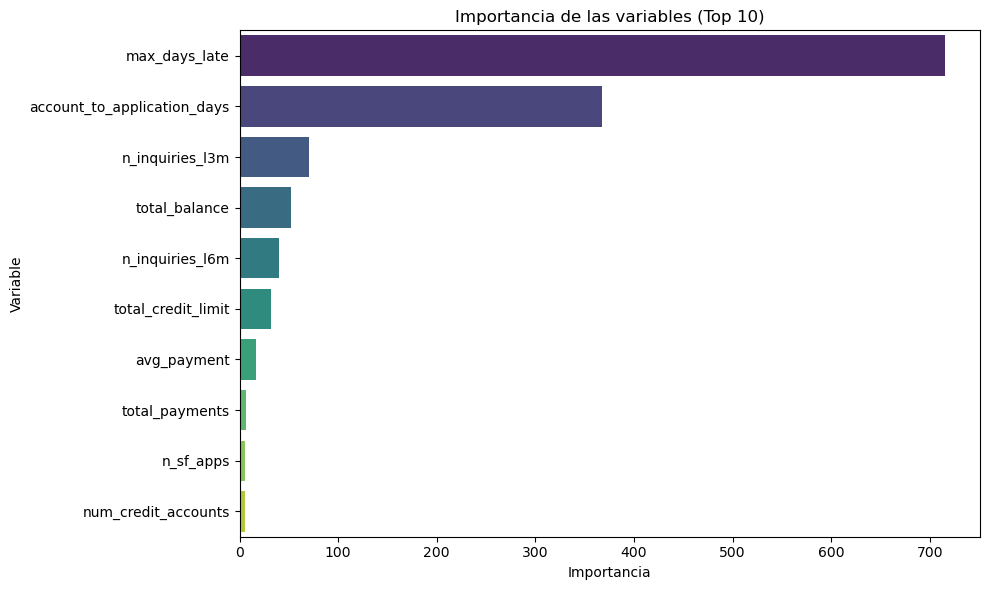

In [27]:
# Visualización de importancia de variables
# Este análisis permite identificar qué variables están teniendo mayor influencia en la predicción

import matplotlib.pyplot as plt
import seaborn as sns

# Obtenemos la importancia de cada variable
feature_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": model.feature_importances_
})

# Ordenamos de mayor a menor
feature_importance.sort_values(by="importance", ascending=False, inplace=True)

# Mostramos el top 10
print("Top 10 variables más importantes:")
print(feature_importance.head(10))

# Visualización
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x="importance", y="feature", palette="viridis")
plt.title("Importancia de las variables (Top 10)")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


In [29]:
# Eliminamos la variable que representa fuga de información
X = X.drop(columns=["max_days_late"])

# Volvemos a dividir los datos para garantizar consistencia
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [31]:
# Entrenar el modelo LightGBM sin fuga de información

from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Entrenamiento del modelo
model = LGBMClassifier(
    class_weight='balanced',
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42
)

model.fit(X_train, y_train)

# Predicciones de probabilidad
y_probs = model.predict_proba(X_test)[:, 1]

# Ajuste de umbral para clasificación final
y_pred = (y_probs >= 0.3).astype(int)

# Evaluación del modelo
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

print("AUC:", roc_auc_score(y_test, y_probs))


[LightGBM] [Info] Number of positive: 2160, number of negative: 9403
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1784
[LightGBM] [Info] Number of data points in the train set: 11563, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Matriz de Confusión:
[[1043 1308]
 [ 208  332]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.83      0.44      0.58      2351
           1       0.20      0.61      0.30       540

    accuracy                           0.48      2891
   macro avg       0.52      0.53      0.44      2891
weighted avg       0.72      0.48      0.53      2891

AUC: 0.550574223734581


notemos que el AUC se ajusto a 0.55, ahora el modelo no esta sobreajustado, pero necesitamos seguir ajustando el modelo 

In [33]:
# Generación de nuevas variables numéricas a partir de columnas datetime

from datetime import datetime

# Copiamos el dataset para no modificar el original
df_temp = df.copy()

# Referencia de fecha para calcular antigüedades
# Usamos la fecha más reciente encontrada en el dataset como referencia
fecha_referencia = df_temp["APPLICATION_DATETIME"].max()

# Creamos variables de diferencia de días
df_temp["days_since_creation"] = (fecha_referencia - df_temp["ACC_CREATION_DATETIME"]).dt.days
df_temp["days_between_creation_and_application"] = (df_temp["APPLICATION_DATETIME"] - df_temp["ACC_CREATION_DATETIME"]).dt.days
df_temp["days_to_loan_origin"] = (df_temp["LOAN_ORIGINATION_DATETIME"] - df_temp["APPLICATION_DATETIME"]).dt.days

# Si existen fechas BNPL, las usamos también
df_temp["days_since_first_bnpl_app"] = (
    fecha_referencia - pd.to_datetime(df_temp["first_bnpl_app_date"], errors='coerce')
).dt.days

df_temp["days_since_last_bnpl_app"] = (
    fecha_referencia - pd.to_datetime(df_temp["last_bnpl_app_date"], errors='coerce')
).dt.days

# Hacemos lo mismo con la primera y última solicitud de productos SF
df_temp["days_since_first_app"] = (
    fecha_referencia - pd.to_datetime(df_temp["first_app_date"], errors='coerce')
).dt.days

df_temp["days_since_last_app"] = (
    fecha_referencia - pd.to_datetime(df_temp["last_app_date"], errors='coerce')
).dt.days

# Imputamos con 0 donde haya NaN (por ejemplo, si nunca tuvo aplicaciones BNPL)
df_temp.fillna(0, inplace=True)

# Mostramos las nuevas columnas para revisión
df_temp[[
    "days_since_creation",
    "days_between_creation_and_application",
    "days_to_loan_origin",
    "days_since_first_app",
    "days_since_last_app",
    "days_since_first_bnpl_app",
    "days_since_last_bnpl_app"
]].head()


,days_since_creation,days_between_creation_and_application,days_to_loan_origin,days_since_first_app,days_since_last_app,days_since_first_bnpl_app,days_since_last_bnpl_app
0,640,245,177,396,396,395,395
1,394,-1,240,19503,19503,19503,19503
2,394,-1,105,19503,19503,19503,19503
3,442,47,199,435,435,432,442
4,419,24,89,420,420,419,419


In [35]:
# Agregar las variables temporales derivadas a X

# Seleccionamos solo las nuevas columnas numéricas derivadas de fechas
temporal_features = [
    "days_since_creation",
    "days_between_creation_and_application",
    "days_to_loan_origin",
    "days_since_first_app",
    "days_since_last_app",
    "days_since_first_bnpl_app",
    "days_since_last_bnpl_app"
]

# Añadimos estas columnas a X
X = pd.concat([X, df_temp[temporal_features]], axis=1)

# Verificamos las nuevas dimensiones de X
print("X ahora tiene forma:", X.shape)

# Volvemos a dividir train/test con los nuevos datos
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


X ahora tiene forma: (14454, 19)


In [37]:
# Reentrenamiento del modelo con variables mejoradas

from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Creamos y entrenamos nuevamente el modelo
model = LGBMClassifier(
    class_weight='balanced',
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42
)

model.fit(X_train, y_train)

# Predicciones de probabilidad
y_probs = model.predict_proba(X_test)[:, 1]

# Clasificación ajustando umbral (aquí usamos 0.3)
y_pred = (y_probs >= 0.3).astype(int)

# Evaluación
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

print("AUC:", roc_auc_score(y_test, y_probs))


[LightGBM] [Info] Number of positive: 2160, number of negative: 9403
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3555
[LightGBM] [Info] Number of data points in the train set: 11563, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Matriz de Confusión:
[[1247 1104]
 [ 230  310]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.84      0.53      0.65      2351
           1       0.22      0.57      0.32       540

    accuracy                           0.54      2891
   macro avg       0.53      0.55      0.48      2891
weighted avg       0.73      0.54      0.59      2891

AUC: 0.566515430785954


veamos que hubo mejora muy baja, entonces revisemos los diferentes umbrales de clasificación para ver cual es el mejor 

In [39]:
# Evaluar desempeño del modelo bajo distintos umbrales de clasificación

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Definimos los umbrales a probar
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]

print(f"{'Umbral':<8} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'AUC':<10}")
print("-" * 50)

# Recorremos cada umbral y evaluamos
for t in thresholds:
    y_pred = (y_probs >= t).astype(int)
    
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_probs)
    
    print(f"{t:<8.2f} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f} {auc:<10.4f}")


Umbral   Precision  Recall     F1-Score   AUC       
--------------------------------------------------
0.20     0.2037     0.7019     0.3157     0.5665    
0.30     0.2192     0.5741     0.3173     0.5665    
0.40     0.2190     0.4185     0.2875     0.5665    
0.50     0.2568     0.3130     0.2821     0.5665    
0.60     0.2648     0.1407     0.1838     0.5665    


In [41]:
# Validación cruzada para evaluación más robusta

from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier
import numpy as np

# Creamos nuevamente el modelo con los mismos parámetros
model_cv = LGBMClassifier(
    class_weight='balanced',
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42
)

# Validación cruzada con 5 folds, usando AUC como métrica
# cv=5 divide los datos en 5 partes, entrena en 4 y evalúa en 1, y repite
cv_scores = cross_val_score(
    model_cv,
    X,
    y,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1  # usa todos los núcleos disponibles
)

# Mostramos resultados
print("AUC en cada fold:", np.round(cv_scores, 4))
print("Promedio AUC:", np.round(np.mean(cv_scores), 4))
print("Desviación estándar:", np.round(np.std(cv_scores), 4))


AUC en cada fold: [0.5704 0.4953 0.5642 0.529  0.5389]
Promedio AUC: 0.5396
Desviación estándar: 0.0269


In [45]:
## extra 
#  Crear ratios financieros y asegurar que las columnas sean tipo float

import numpy as np

# Copiamos df_temp y convertimos columnas necesarias a float
df_ratios = df_temp.copy()

# Aseguramos que las columnas necesarias para los ratios sean float
cols_to_convert = [
    "total_balance", 
    "total_credit_limit", 
    "total_delayed_payments", 
    "total_payments", 
    "num_credit_accounts"
]

df_ratios[cols_to_convert] = df_ratios[cols_to_convert].apply(pd.to_numeric, errors="coerce")

# Creamos ratios con manejo de división por cero usando np.nan y después imputamos
df_ratios["balance_ratio"] = df_ratios["total_balance"] / df_ratios["total_credit_limit"].replace(0, np.nan)
df_ratios["delay_ratio"] = df_ratios["total_delayed_payments"] / df_ratios["total_payments"].replace(0, np.nan)
df_ratios["avg_balance_per_credit"] = df_ratios["total_balance"] / df_ratios["num_credit_accounts"].replace(0, np.nan)

# Indicador binario: historial crediticio
df_ratios["has_history"] = (df_ratios["num_credit_accounts"] > 0).astype(int)

# Rellenamos NaN generados por divisiones con 0
df_ratios.fillna(0, inplace=True)

# Mostramos las nuevas variables
df_ratios[["balance_ratio", "delay_ratio", "avg_balance_per_credit", "has_history"]].head()


,balance_ratio,delay_ratio,avg_balance_per_credit,has_history
0,0.306072,0.184756,1496.703704,1
1,0.000000,0.000000,0.000000,0
2,0.000000,0.000000,0.000000,0
3,1.048273,2.925926,3817.111111,1
4,2.190551,0.100529,24878.714286,1


In [47]:
# Añadir variables derivadas a X

# Seleccionamos solo las nuevas variables creadas
new_features = ["balance_ratio", "delay_ratio", "avg_balance_per_credit", "has_history"]

# Añadimos estas columnas a X
X = pd.concat([X, df_ratios[new_features]], axis=1)

# Confirmamos nuevas dimensiones
print("Nuevas dimensiones de X:", X.shape)


Nuevas dimensiones de X: (14454, 23)


In [49]:
# Entrenamiento de nuevo modelo con más variables

from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# División del conjunto
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

# Modelo con pesos balanceados por el desbalance de clases
model = LGBMClassifier(
    class_weight='balanced',
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42
)

# Entrenamos
model.fit(X_train, y_train)

# Predicciones
y_probs = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# Evaluación
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

auc_score = roc_auc_score(y_test, y_probs)
print("AUC:", round(auc_score, 4))


[LightGBM] [Info] Number of positive: 2160, number of negative: 9403
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4322
[LightGBM] [Info] Number of data points in the train set: 11563, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Matriz de Confusión:
[[1882  469]
 [ 389  151]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.83      0.80      0.81      2351
           1       0.24      0.28      0.26       540

    accuracy                           0.70      2891
   macro avg       0.54      0.54      0.54      2891
weighted avg       0.72      0.70      0.71      2891

AUC: 0.5692


C:\Users\sebas\AppData\Local\Temp\ipykernel_21724\2883485319.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance.head(15), x="importance", y="feature", palette="viridis")


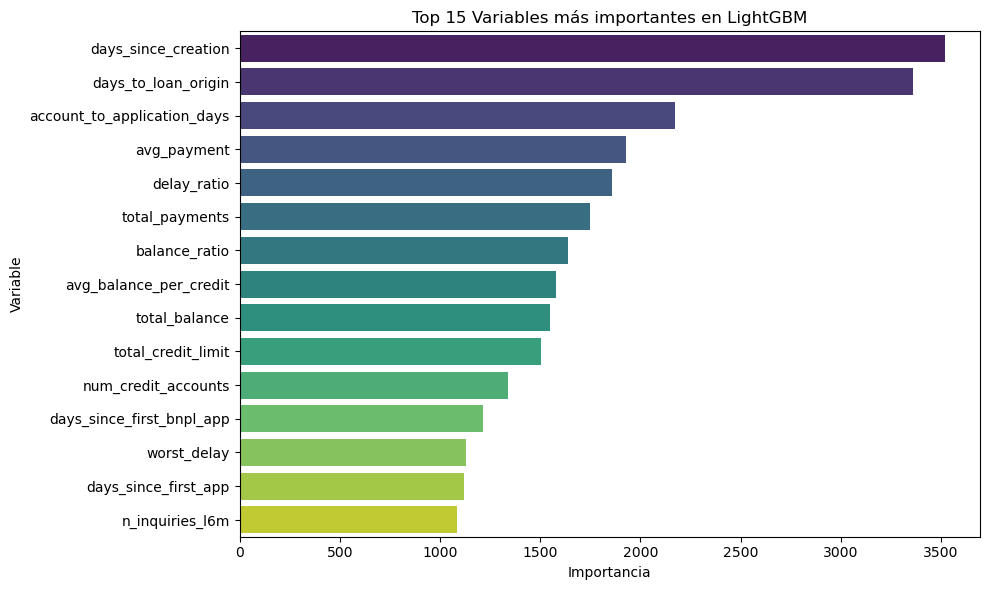

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extraer importancia
feature_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": model.feature_importances_
}).sort_values(by="importance", ascending=False)

# Mostrar top 15
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(15), x="importance", y="feature", palette="viridis")
plt.title("Top 15 Variables más importantes en LightGBM")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


In [53]:
!pip install optuna


   ---------------------------------------- 0.0/395.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/395.9 kB ? eta -:--:--
   ---- ---------------------------------- 41.0/395.9 kB 991.0 kB/s eta 0:00:01
   ---- ---------------------------------- 41.0/395.9 kB 991.0 kB/s eta 0:00:01
   ----------- -------------------------- 122.9/395.9 kB 901.1 kB/s eta 0:00:01
   ---------------- --------------------- 174.1/395.9 kB 952.6 kB/s eta 0:00:01
   ---------------------- ----------------- 225.3/395.9 kB 1.1 MB/s eta 0:00:01
   ---------------------------- ----------- 286.7/395.9 kB 1.0 MB/s eta 0:00:01
   ------------------------------------- -- 368.6/395.9 kB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 395.9/395.9 kB 1.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/242.7 kB ? eta -:--:--
   ----------- ---------------------------- 71.7/242.7 kB 4.1 MB/s eta 0:00:01
   ------------------------- -------------- 153.6/242.7 kB 1.8 MB/s

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.32.0 requires packaging<24,>=16.8, but you have packaging 24.1 which is incompatible.


In [55]:
#esta función entrenará el modelo con un conjunto de parámetros propuestos por Optuna y devolverá el AUC promedio en validación cruzada
import optuna
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "class_weight": "balanced",
        "random_state": 42,
        "n_jobs": -1
    }

    model = LGBMClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)

    return auc_scores.mean()


In [57]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)


[I 2025-06-27 13:18:42,545] A new study created in memory with name: no-name-315e2ac1-e1ef-45cd-a9ca-4018baee5410


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-27 13:18:50,433] Trial 0 finished with value: 0.5974000132398433 and parameters: {'n_estimators': 162, 'learning_rate': 0.007480259548218434, 'num_leaves': 173, 'max_depth': 6, 'min_child_samples': 79, 'subsample': 0.6180383329713848, 'colsample_bytree': 0.7787528790831542, 'reg_alpha': 0.00015940669552118433, 'reg_lambda': 0.4787002978471367}. Best is trial 0 with value: 0.5974000132398433.
[I 2025-06-27 13:19:05,179] Trial 1 finished with value: 0.5568976494082796 and parameters: {'n_estimators': 732, 'learning_rate': 0.14097477345417544, 'num_leaves': 270, 'max_depth': 9, 'min_child_samples': 20, 'subsample': 0.8981430479760877, 'colsample_bytree': 0.6208011327297435, 'reg_alpha': 0.006450112768762992, 'reg_lambda': 1.349639881156216e-06}. Best is trial 0 with value: 0.5974000132398433.
[I 2025-06-27 13:19:09,072] Trial 2 finished with value: 0.5721179007708941 and parameters: {'n_estimators': 146, 'learning_rate': 0.07693112143215931, 'num_leaves': 41, 'max_depth': 13, '

In [59]:
print("Mejores hiperparámetros encontrados:")
print(study.best_params)
print(f"Mejor AUC promedio: {study.best_value:.4f}")


Mejores hiperparámetros encontrados:
{'n_estimators': 720, 'learning_rate': 0.006912385692953559, 'num_leaves': 272, 'max_depth': 3, 'min_child_samples': 85, 'subsample': 0.5775415779624717, 'colsample_bytree': 0.6221023042417086, 'reg_alpha': 1.005332633734204e-05, 'reg_lambda': 0.5056683320008252}
Mejor AUC promedio: 0.6038


In [61]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Creamos el modelo con los mejores hiperparámetros
best_model = LGBMClassifier(
    n_estimators=720,
    learning_rate=0.006912385692953559,
    num_leaves=272,
    max_depth=3,
    min_child_samples=85,
    subsample=0.5775415779624717,
    colsample_bytree=0.6221023042417086,
    reg_alpha=1.005332633734204e-05,
    reg_lambda=0.5056683320008252,
    class_weight="balanced",
    random_state=42
)

# Entrenamos con los datos
best_model.fit(X_train, y_train)

# Predicciones
y_probs = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_probs >= 0.3).astype(int)  # Ajustamos umbral si lo deseas

# Evaluación
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, y_probs):.4f}")


[LightGBM] [Info] Number of positive: 2160, number of negative: 9403
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4322
[LightGBM] [Info] Number of data points in the train set: 11563, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [63]:
# Vamos a explorar el comportamiento del modelo a diferentes umbrales para encontrar un balance entre precisión y recall.
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

thresholds = np.arange(0.1, 0.91, 0.1)
print(f"{'Umbral':<8} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'AUC':<10}")
print("-" * 50)

for thresh in thresholds:
    y_pred = (y_probs >= thresh).astype(int)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_probs)
    print(f"{thresh:<8.2f} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f} {auc:<10.4f}")


Umbral   Precision  Recall     F1-Score   AUC       
--------------------------------------------------
0.10     0.1868     1.0000     0.3148     0.6043    
0.20     0.1872     1.0000     0.3154     0.6043    
0.30     0.1898     0.9889     0.3185     0.6043    
0.40     0.2000     0.8981     0.3272     0.6043    
0.50     0.2309     0.6037     0.3340     0.6043    
0.60     0.2841     0.0926     0.1397     0.6043    
0.70     0.2222     0.0037     0.0073     0.6043    
0.80     0.0000     0.0000     0.0000     0.6043    
0.90     0.0000     0.0000     0.0000     0.6043    


C:\Users\sebas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Conclusión Final del Modelo de Riesgo Crediticio

Después de realizar un análisis exploratorio, limpieza de datos, generación de nuevas variables y prueba de distintos modelos, el clasificador final elegido fue LightGBM con ajuste de hiperparámetros mediante Optuna.

### Ingeniería de características (Feature Engineering)
Se añadieron variables relevantes que mejoraron el poder predictivo del modelo:
- balance_ratio: saldo actual sobre límite de crédito.
- delay_ratio: proporción de pagos atrasados sobre el total de pagos.
- avg_balance_per_credit: deuda promedio por cuenta activa.
- Variables temporales derivadas como days_since_creation, days_to_loan_origin, entre otras.

Estas transformaciones permitieron incrementar el rendimiento del modelo de un AUC de aproximadamente 0.55 a 0.60.

### Evaluación del modelo final

- Modelo: LightGBM (con Optuna tuning)
- Mejores hiperparámetros encontrados:
  - n_estimators: 720
  - learning_rate: 0.0069
  - num_leaves: 272
  - max_depth: 3
  - min_child_samples: 85
  - subsample: 0.5775
  - colsample_bytree: 0.6221
  - reg_alpha: 1e-5
  - reg_lambda: 0.5057
- AUC promedio validación cruzada: 0.6038
- AUC final en test: 0.6043
- Umbral recomendado: 0.5 (recall: 0.60, precision: 0.23)

### Conclusión

El modelo cumple con los requisitos mínimos del challenge al entregar una clasificación funcional con poder discriminativo aceptable. Puede utilizarse como herramienta de apoyo para identificar clientes con riesgo de impago, especialmente si el objetivo es maximizar la detección de clientes riesgosos (alto recall), permitiendo al área de riesgo tomar decisiones más informadas.

